In [1]:
import pandas as pd
import numpy as np
import calendar
from time import time
from datetime import datetime
import re 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_train = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")
#data_train_orig = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")

In [3]:
dept_list = sorted(list(data_train.DepartmentDescription.dropna().unique()))

In [4]:
weekdays = list(calendar.day_name)
dept_list_sum = dict.fromkeys(dept_list, np.sum)
weekday_dict = dict.fromkeys(weekdays, np.max)
feature_dict = {"TripType": np.max, 'NumItems': np.sum, 'Return': np.max}
feature_dict = {**feature_dict, **weekday_dict, **dept_list_sum}

In [5]:
def transform_data(data):
    dummies = pd.get_dummies(data.Weekday)
    data[dummies.columns] = dummies
    
    dummies = pd.get_dummies(data.DepartmentDescription)
    dummies = dummies.apply(lambda x: x*data["ScanCount"])
    data[dummies.columns] = dummies 

    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.Return != 1, 'Return'] = 0
    
    data = data.rename(columns={"ScanCount":"NumItems"})
    
    grouped = data.groupby("VisitNumber")
    grouped = grouped.aggregate(feature_dict)
    data = grouped[["TripType", "NumItems", "Return"] + weekdays + dept_list]

    return data

In [6]:
data_new = transform_data(data_train)

In [7]:
def add_category_counts(data):
    alist = []
    for array in np.asarray(data.loc[:, dept_list[0]:]):
        count = 0
        count = sum(x > 0 for x in array)
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(3, 'CategoryCounts', cat_counts)
    return data

In [8]:
data_new = add_category_counts(data_new)

In [9]:
data_new.shape

(95674, 78)

In [10]:
def fineline_dummies(data):
    values = data.FinelineNumber
    counts = values.value_counts()
    mask = values.isin(counts[counts > 500].index)
    values[~mask] = "-"
    dummies = pd.get_dummies(values).drop('-', axis=1)

    dummies.columns = ['fln_'+str(col) for col in dummies.columns]
    dummies = pd.concat([dummies, data.VisitNumber], axis=1)
    dummies = dummies.groupby("VisitNumber")
    dummies = dummies.aggregate(np.sum)
    return dummies

In [11]:
start = datetime.now()
fln_dummies = fineline_dummies(data_train)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


'0:00:20.542889'

In [12]:
data_new = data_new.join(fln_dummies)

In [13]:
data_new.shape

(95674, 351)

In [14]:
def Upc_dummies(data):
    values = data.Upc
    counts = values.value_counts()
    mask = values.isin(counts[counts > 300].index)
    values[~mask] = "-"
    dummies = pd.get_dummies(values).drop('-', axis=1)

    dummies.columns = ['upc_'+str(col) for col in dummies.columns]
    dummies = pd.concat([dummies, data.VisitNumber], axis=1)
    dummies = dummies.groupby("VisitNumber")
    dummies = dummies.aggregate(np.sum)
    return dummies

In [15]:
start = datetime.now()
upc_dummies = Upc_dummies(data_train)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


'0:00:08.350860'

In [16]:
data_new = data_new.join(upc_dummies)

In [17]:
data_new.shape

(95674, 451)

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [19]:
X = data_new.drop('TripType', axis=1)

trip_types = sorted(data_train.TripType.unique())
trip_types_map = dict(zip(trip_types, np.arange(0, len(trip_types))))
y = data_new.TripType.map(trip_types_map)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
len(X.columns)

450

In [66]:
y

VisitNumber
5         37
7         22
8         18
9          5
10         5
11        27
12        33
15        13
17         3
19        34
20         4
23         6
25         5
26        31
28        17
29         5
30         6
31         5
32         5
33         5
40         5
41         5
42         5
43        30
45         5
47        27
49         9
50         6
51         5
53         5
          ..
191276    13
191277    36
191280     5
191283    36
191286    32
191287    18
191289     5
191291     5
191293    28
191298    32
191301    34
191304    28
191305    23
191311     6
191312    34
191313    22
191318     4
191322    30
191324    32
191326    30
191329    16
191331     6
191335    24
191337    30
191342     5
191343    17
191344    14
191345    31
191346    31
191347     5
Name: TripType, Length: 95674, dtype: int64

In [37]:
def create_model_1hl(nodes_l1=512, dropout_l1=0.3):
    model = Sequential()
    model.add(Dense(output_dim=nodes_l1, activation="relu", input_dim=len(X.columns)))
    model.add(Dropout(dropout_l1))
            
    model.add(Dense(output_dim=len(trip_types), activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

In [71]:
model_1hl = KerasClassifier(build_fn=create_model_1hl, epochs=100, batch_size=1000, verbose=2)

In [72]:
callbacks = [EarlyStopping(monitor="val_acc", patience=20), 
             ModelCheckpoint(filepath="best_model.h5", monitor="val_acc", save_best_only=True)]

In [81]:
start = datetime.now()
model_1hl.fit(X_train, y_train, validation_split=0.25, batch_size=1000, callbacks=callbacks)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Train on 53816 samples, validate on 17939 samples
Epoch 1/100
 - 6s - loss: 2.2080 - acc: 0.5035 - val_loss: 1.4943 - val_acc: 0.6294
Epoch 2/100
 - 5s - loss: 1.3361 - acc: 0.6381 - val_loss: 1.1306 - val_acc: 0.6804
Epoch 3/100
 - 5s - loss: 1.1048 - acc: 0.6716 - val_loss: 1.0162 - val_acc: 0.6939
Epoch 4/100
 - 4s - loss: 1.0037 - acc: 0.6896 - val_loss: 0.9663 - val_acc: 0.7014
Epoch 5/100
 - 4s - loss: 0.9415 - acc: 0.7038 - val_loss: 0.9207 - val_acc: 0.7064
Epoch 6/100
 - 5s - loss: 0.8922 - acc: 0.7138 - val_loss: 0.8989 - val_acc: 0.7081
Epoch 7/100
 - 5s - loss: 0.8563 - acc: 0.7217 - val_loss: 0.8800 - val_acc: 0.7095
Epoch 8/100
 - 5s - loss: 0.8258 - acc: 0.7281 - val_loss: 0.8603 - val_acc: 0.7155
Epoch 9/100
 - 5s - loss: 0.8023 - acc: 0.7340 - val_loss: 0.8490 - val_acc: 0.7162
Epoch 10/100
 - 5s - loss: 0.7773 - acc: 0.7401 - val_loss: 0.8400 - val_acc: 0.7232
Epoch 11/100
 - 4s - loss: 0.7585 - acc: 0.7444 - val_loss: 0.8301 - val_acc: 0.7214
Epoch 12/100
 - 5s - los

'0:03:24.330713'

In [82]:
from keras import models

In [83]:
model_1hl.model.save("my_model.h5")

In [84]:
model = load_model("my_model.h5")

In [77]:
model.metrics_names[0], model.metrics_names[1]

('loss', 'acc')

In [85]:
model.evaluate(X, to_categorical(y))

95674/95674 [==============================] - 8s 88us/step


[0.5983671174825482, 0.8081610468821618]

In [86]:
model.evaluate(X_test, to_categorical(y_test))

23919/23919 [==============================] - 2s 89us/step


[0.8749101496374753, 0.7178811823386274]

In [79]:
model.score(X_test, y_test)

AttributeError: 'Sequential' object has no attribute 'score'

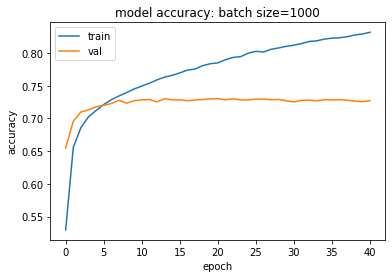

In [25]:
plt.plot(hist_1hl.history['acc'])
plt.plot(hist_1hl.history['val_acc'])
plt.title('model accuracy: batch size=1000')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

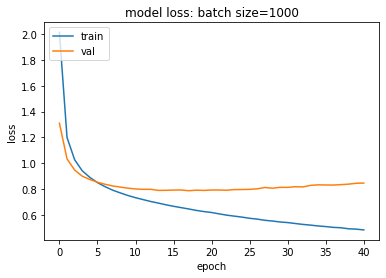

In [26]:
plt.plot(hist_1hl.history['loss'])
plt.plot(hist_1hl.history['val_loss'])
plt.title('model loss: batch size=1000')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
scoring = ['accuracy', 'neg_log_loss']
cv = StratifiedKFold(n_splits=4)

In [28]:
nn_1hl = KerasClassifier(build_fn=create_model_1hl, epochs=20, batch_size=1000, verbose=2)

In [29]:
start = datetime.now()
hist_cross_val = cross_validate(nn_1hl, X, y, scoring=scoring, cv=cv)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/20
 - 11s - loss: 2.0312 - acc: 0.5238
Epoch 2/20
 - 12s - loss: 1.2015 - acc: 0.6566
Epoch 3/20
 - 8s - loss: 1.0257 - acc: 0.6860
Epoch 4/20
 - 9s - loss: 0.9425 - acc: 0.7024
Epoch 5/20
 - 12s - loss: 0.8871 - acc: 0.7124
Epoch 6/20
 - 12s - loss: 0.8479 - acc: 0.7221
Epoch 7/20
 - 10s - loss: 0.8178 - acc: 0.7281
Epoch 8/20
 - 10s - loss: 0.7903 - acc: 0.7346
Epoch 9/20
 - 8s - loss: 0.7694 - acc: 0.7404
Epoch 10/20
 - 8s - loss: 0.7496 - acc: 0.7451
Epoch 11/20
 - 7s - loss: 0.7304 - acc: 0.7499
Epoch 12/20
 - 8s - loss: 0.7178 - acc: 0.7541
Epoch 13/20
 - 7s - loss: 0.7006 - acc: 0.7598
Epoch 14/20
 - 8s - loss: 0.6908 - acc: 0.7625
Epoch 15/20
 - 7s - loss: 0.6775 - acc: 0.7672
Epoch 16/20
 - 8s - loss: 0.6655 - acc: 0.7704
Epoch 17/20
 - 7s - loss: 0.6543 - acc: 0.7733
Epoch 18/20
 - 8s - loss: 0.6431 - acc: 0.7786
Epoch 19/20
 - 8s - loss: 0.6334 - acc: 0.7797
Epoch 20/20
 - 8s - loss: 0.6221 - acc: 0.7851


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/20
 - 8s - loss: 2.0278 - acc: 0.5211
Epoch 2/20
 - 8s - loss: 1.1982 - acc: 0.6594
Epoch 3/20
 - 7s - loss: 1.0223 - acc: 0.6880
Epoch 4/20
 - 8s - loss: 0.9396 - acc: 0.7031
Epoch 5/20
 - 7s - loss: 0.8844 - acc: 0.7145
Epoch 6/20
 - 8s - loss: 0.8464 - acc: 0.7234
Epoch 7/20
 - 7s - loss: 0.8155 - acc: 0.7288
Epoch 8/20
 - 8s - loss: 0.7905 - acc: 0.7356
Epoch 9/20
 - 7s - loss: 0.7699 - acc: 0.7410
Epoch 10/20
 - 7s - loss: 0.7485 - acc: 0.7476
Epoch 11/20
 - 8s - loss: 0.7307 - acc: 0.7531
Epoch 12/20
 - 7s - loss: 0.7182 - acc: 0.7554
Epoch 13/20
 - 8s - loss: 0.7043 - acc: 0.7601
Epoch 14/20
 - 8s - loss: 0.6904 - acc: 0.7656
Epoch 15/20
 - 8s - loss: 0.6782 - acc: 0.7665
Epoch 16/20
 - 7s - loss: 0.6666 - acc: 0.7719
Epoch 17/20
 - 8s - loss: 0.6555 - acc: 0.7741
Epoch 18/20
 - 7s - loss: 0.6436 - acc: 0.7780
Epoch 19/20
 - 8s - loss: 0.6341 - acc: 0.7815
Epoch 20/20
 - 7s - loss: 0.6233 - acc: 0.7854


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/20
 - 6s - loss: 2.0251 - acc: 0.5287
Epoch 2/20
 - 5s - loss: 1.1886 - acc: 0.6623
Epoch 3/20
 - 5s - loss: 1.0120 - acc: 0.6915
Epoch 4/20
 - 5s - loss: 0.9293 - acc: 0.7084
Epoch 5/20
 - 5s - loss: 0.8744 - acc: 0.7178
Epoch 6/20
 - 6s - loss: 0.8354 - acc: 0.7264
Epoch 7/20
 - 5s - loss: 0.8016 - acc: 0.7343
Epoch 8/20
 - 5s - loss: 0.7787 - acc: 0.7395
Epoch 9/20
 - 5s - loss: 0.7555 - acc: 0.7455
Epoch 10/20
 - 5s - loss: 0.7366 - acc: 0.7509
Epoch 11/20
 - 5s - loss: 0.7177 - acc: 0.7558
Epoch 12/20
 - 5s - loss: 0.7028 - acc: 0.7605
Epoch 13/20
 - 5s - loss: 0.6901 - acc: 0.7633
Epoch 14/20
 - 5s - loss: 0.6741 - acc: 0.7684
Epoch 15/20
 - 5s - loss: 0.6622 - acc: 0.7720
Epoch 16/20
 - 5s - loss: 0.6506 - acc: 0.7750
Epoch 17/20
 - 5s - loss: 0.6394 - acc: 0.7800
Epoch 18/20
 - 5s - loss: 0.6268 - acc: 0.7836
Epoch 19/20
 - 5s - loss: 0.6185 - acc: 0.7851
Epoch 20/20
 - 5s - loss: 0.6086 - acc: 0.7891


C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=450, units=512)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  


Epoch 1/20
 - 6s - loss: 2.0181 - acc: 0.5316
Epoch 2/20
 - 5s - loss: 1.1926 - acc: 0.6575
Epoch 3/20
 - 5s - loss: 1.0200 - acc: 0.6860
Epoch 4/20
 - 6s - loss: 0.9374 - acc: 0.7012
Epoch 5/20
 - 7s - loss: 0.8816 - acc: 0.7138
Epoch 6/20
 - 8s - loss: 0.8412 - acc: 0.7227
Epoch 7/20
 - 8s - loss: 0.8110 - acc: 0.7282
Epoch 8/20
 - 8s - loss: 0.7870 - acc: 0.7343
Epoch 9/20
 - 8s - loss: 0.7656 - acc: 0.7398
Epoch 10/20
 - 8s - loss: 0.7468 - acc: 0.7457
Epoch 11/20
 - 8s - loss: 0.7284 - acc: 0.7496
Epoch 12/20
 - 7s - loss: 0.7155 - acc: 0.7548
Epoch 13/20
 - 8s - loss: 0.7005 - acc: 0.7594
Epoch 14/20
 - 7s - loss: 0.6873 - acc: 0.7645
Epoch 15/20
 - 8s - loss: 0.6771 - acc: 0.7671
Epoch 16/20
 - 7s - loss: 0.6648 - acc: 0.7709
Epoch 17/20
 - 8s - loss: 0.6519 - acc: 0.7746
Epoch 18/20
 - 7s - loss: 0.6429 - acc: 0.7779
Epoch 19/20
 - 9s - loss: 0.6328 - acc: 0.7806
Epoch 20/20
 - 7s - loss: 0.6233 - acc: 0.7844


'0:09:52.035571'

In [30]:
hist_cross_val

{'fit_time': array([180.30806828, 151.24317241, 106.47849917, 144.92785668]),
 'score_time': array([2.43006611, 2.40151691, 1.47708988, 2.38353062]),
 'test_accuracy': array([0.72815777, 0.72885749, 0.71744585, 0.73128085]),
 'test_neg_log_loss': array([-0.79691686, -0.80656287, -0.85743657, -0.79650515])}

In [31]:
hist_cross_val['test_accuracy'].mean(), hist_cross_val['test_neg_log_loss'].mean()

(0.7264354901592518, -0.8143553656094847)

In [32]:
nn_1hl = KerasClassifier(build_fn=create_model_1hl, epochs=30, batch_size=1000, verbose=2)